# Explore `meta-kaggle` Dataset

## --- Effort Estimation

Pre-requisites: 

1. Install Python package `kaggle`
2. [Create token](https://www.kaggle.com/docs/api) and 
3. Put the `kaggle.json` file to the `.kaggle` folder of your home directory
4. Download dataset `meta-kaggle` if haven't yet, by excuting: 
   ```python
   from metakaggle import api
   api.download_rawdata(rawdata_path)
   ```

In [ ]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import metakaggle as mk

In [2]:
rawdata_path = os.path.abspath('./rawdata')

### 1. Merge Datasets

- Submissions
- Teams
- Competitions

In [3]:
# Submissions
# - TeamId
# - SubmissionDate
tbl_submissions = mk.table_filter( \
	'Submissions', rawdata_path,
	fields = ['Id', 'TeamId', 'SubmissionDate', 'IsAfterDeadline',
		'PublicScoreLeaderboardDisplay', 'PrivateScoreFullPrecision'],
	fields_index = ['Id'],
	fields_datetime = ['SubmissionDate'],
)
# drop all submissions after deadlines
tbl_submissions = tbl_submissions[~tbl_submissions['IsAfterDeadline']]
tbl_submissions.drop('IsAfterDeadline', axis=1, inplace=True)
# rename long name
tbl_submissions.rename(columns={
	'PublicScoreLeaderboardDisplay': 'PublicScore',
	'PrivateScoreFullPrecision': 'PrivateScore'
}, inplace=True)

In [4]:
# Mapping: Teams
# - CompetitionId
map_teams_competitions = mk.table_filter( \
	'Teams', rawdata_path,
	fields = ['Id', 'CompetitionId'],
	fields_index = ['Id'],
)
# Map: Competitions
# - EnabledDate
# - DeadlineDate
map_competitions_dates = mk.table_filter( \
	'Competitions', rawdata_path,
	fields=['Id', 'EnabledDate', 'DeadlineDate'],
	fields_datetime=['EnabledDate', 'DeadlineDate'],
	fields_index=['Id'],
)

In [49]:
# Merge `Submissions` and `TeamsCompetition`
tbl_submissions = pd.merge(tbl_submissions, map_teams_competitions,
	how = 'left', left_on = 'TeamId', right_on = 'Id', sort = False,
	suffixes=('', '_Team'))
tbl_submissions.drop(columns='Id_Team', inplace=True)

# Further merge  with `Competitions`
tbl_submissions = pd.merge(tbl_submissions, map_competitions_dates,
	how='left', left_on='CompetitionId', right_on='Id', sort = False,
	suffixes=('', '_Competitions'))
tbl_submissions.drop(columns='Id_Competitions', inplace=True)

tbl_submissions.set_index('Id', inplace = True)
tbl_submissions.dtypes

TeamId                                int64
SubmissionDate               datetime64[ns]
PublicScore                         float64
PrivateScore                        float64
CompetitionId                         int64
EnabledDate                  datetime64[ns]
DeadlineDate                 datetime64[ns]
CompetitionId_Team                    int64
EnabledDate_Competitions     datetime64[ns]
DeadlineDate_Competitions    datetime64[ns]
dtype: object

In [52]:
all_contests = tbl_submissions['CompetitionId'].unique()
print('How many contests in total?\n', len(all_contests))

How many contests in total?
 5693


### 2. Visualize Submissions

In [ ]:


def plot_contest_submissions(submissions: pd.DataFrame, max_nteams: int = 5):
	"""
	"""
	contest_time_start = submissions['EnabledDate_Competitions'].iloc[0]
	contest_time_end = submissions['DeadlineDate_Competitions'].iloc[0]
	contest_teams_n_submits = submissions.groupby('TeamId').size().sort_values(ascending=False)

	plt.figure(figsize=(10, 5))
	idx_team = 0
	y_ticks = ([], [])

	for team in contest_teams_n_submits.index:
		team_submissiondates = submissions.loc[submissions['TeamId'] == team, ['SubmissionDate']]
		if idx_team < max_nteams:
			idx_team += 1
			team_loc = idx_team
			y_ticks[0].append(team_loc)
			y_ticks[1].append(team)
			plt.hlines(y=team_loc, xmax=contest_time_start, xmin=contest_time_end)
			plt.vlines(x=team_submissiondates, ymax=idx_team + 0.1, ymin=idx_team - 0.1)
	plt.xlim(contest_time_start, contest_time_end)
	plt.yticks(*y_ticks)
	plt.ylabel('Team', rotation=0)
	ax = plt.gca()
	#ax.xaxis.set_label_coords(1.0, -0.05)
	ax.yaxis.set_label_coords(-0.05, 1.0)
	#plt.tight_layout()
	plt.show()

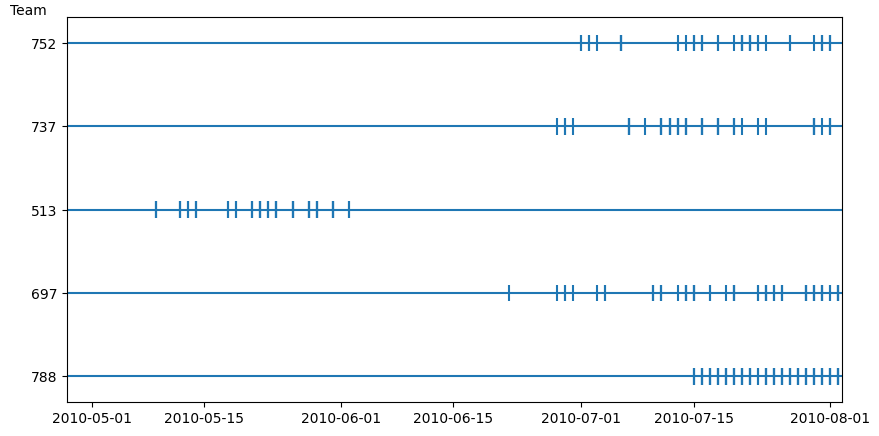

In [150]:
# Select one contest indexed by `2435` as example
submissions_2435 = tbl_submissions[tbl_submissions['CompetitionId'] == 2435]

plot_contest_submissions(submissions_2435)

### 3. Estimate the Arrival Intensity (Rate) of Submissions over Time

> Reference: 
> 
> Adams, R. P., Murray, I., & MacKay, D. J. C. (2009). Tractable nonparametric Bayesian inference in Poisson processes with Gaussian process intensities. Proceedings of the 26th Annual International Conference on Machine Learning, 9–16. https://doi.org/10.1145/1553374.1553376


For each team $i$, the inhomogeneous Poisson rate is denoted by $\lambda_i(s)$, $s\in \mathcal{S}$, where $\mathcal{S}$ stands for the contest duration.